In [1]:
import base64
from IPython.display import HTML, display

In [2]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

class MemeSearchEngine:
    def __init__(self, data_path: str, model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        self.df = pd.read_parquet(data_path)
        self.model = SentenceTransformer(model_name, cache_folder=r'..\models', device='cuda')
        self.meme_embeddings = np.array(self.df['embedding'].tolist())
    
    def search(self, query: str, top_k: int = 5) -> pd.DataFrame:
        query_embedding = self.model.encode([query], convert_to_numpy=True)
        similarities = cosine_similarity(query_embedding, self.meme_embeddings)[0]
        top_indices = similarities.argsort()[-top_k:][::-1]

        results = []
        for idx in top_indices:
            row = self.df.iloc[idx].copy()
            row['score'] = similarities[idx]
            results.append(row)
        
        return pd.DataFrame(results)

    def get_image_bytes(self, idx: int) -> bytes:
        return self.df.iloc[idx]['image_bytes']


In [3]:
def bytes_to_html_image(byte_data, width=100):
    img_str = base64.b64encode(byte_data).decode('utf-8')
    return f'<img src="data:image/jpeg;base64,{img_str}" width="{width}">'

def display_df_with_images(df, n_rows=10, image_width=100):
    display_df = df[:n_rows].copy()
    display_df['image_preview'] = display_df['local_path'].apply(lambda x: bytes_to_html_image(x, width=image_width))
    display(HTML(display_df.drop('local_path', axis=1).to_html(escape=False, index=False)))

Найдено мемов: 3

1581. research cat (схожесть: 0.733)

2171. Hoody Cat (схожесть: 0.714)

2025. Woah Kitty (схожесть: 0.691)


local_path
""
""
""

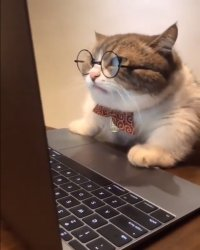
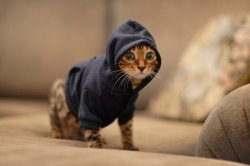
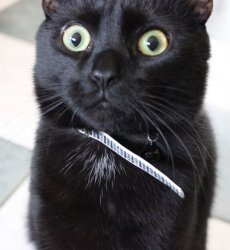

In [4]:
engine = MemeSearchEngine('../data/memes_post.parquet')

results = engine.search("Кот", top_k=3)

print(f"Найдено мемов: {len(results)}")
for i, row in results.iterrows():
    print(f"\n{i+1}. {row['name']} (схожесть: {row['score']:.3f})")

display(HTML(pd.DataFrame(results['local_path'].apply(lambda x: bytes_to_html_image(x, 300))).to_html(escape=False, index=False)))